In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder
import scipy
import itertools
from sklearn.feature_extraction.text import CountVectorizer
import unicodedata, re, string
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer


## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_cnt.csv')

In [ ]:
len(dataset['author_id'].unique())

20

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
y_train[:10]

171      69
459    1181
257     204
742    1626
746    1626
694    3141
797    1626
709    3141
115    1230
181      69
Name: author_id, dtype: int64

## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
for i in range(10):
  print(y_train[i])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
index_to_id_mapping = {index: author_id for index, author_id in enumerate(one_hot_encoder.categories_[0])}
index_to_id_mapping

{0: 17,
 1: 45,
 2: 65,
 3: 69,
 4: 120,
 5: 204,
 6: 213,
 7: 410,
 8: 505,
 9: 585,
 10: 594,
 11: 791,
 12: 1060,
 13: 1181,
 14: 1230,
 15: 1626,
 16: 1758,
 17: 3141,
 18: 5166,
 19: 8137}

# TextVectorization

## Model 3


In [ ]:
embedding_dim = 256
vocab_size = 70000
sequence_length = 8000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
model = tf.keras.Sequential([
    vect_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 8000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 8000, 256)         17920000  
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/15
74/74 [==============================] - 13s 118ms/step - loss: 2.9064 - accuracy: 0.1229 - val_loss: 2.8368 - val_accuracy: 0.1818
Epoch 2/15
74/74 [==============================] - 9s 117ms/step - loss: 2.4654 - accuracy: 0.2526 - val_loss: 2.4302 - val_accuracy: 0.2273
Epoch 3/15
74/74 [==============================] - 9s 118ms/step - loss: 2.1348 - accuracy: 0.2935 - val_loss: 2.2111 - val_accuracy: 0.2879
Epoch 4/15
74/74 [==============================] - 8s 112ms/step - loss: 1.8703 - accuracy: 0.4061 - val_loss: 1.9509 - val_accuracy: 0.4242
Epoch 5/15
74/74 [==============================] - 9s 117ms/step - loss: 1.5579 - accuracy: 0.5119 - val_loss: 1.7217 - val_accuracy: 0.5152
Epoch 6/15
74/74 [==============================] - 8s 105ms/step - loss: 1.2764 - accuracy: 0.6297 - val_loss: 1.4510 - val_accuracy: 0.5455
Epoch 7/15
74/74 [==============================] - 8s 113ms/step - loss: 1.0446 - accuracy: 0.6775 - val_loss: 1.2539 - val_accuracy: 0.5606
Epoch

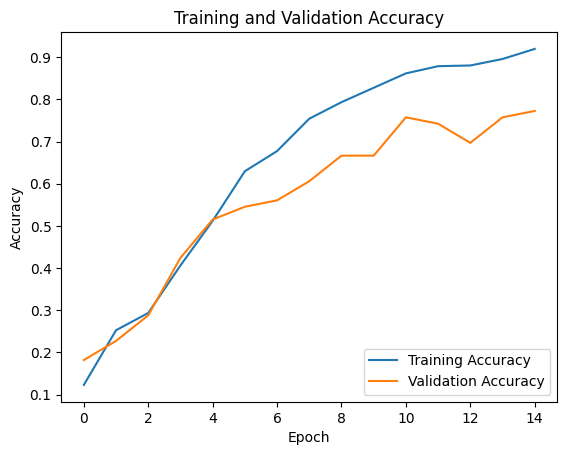

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

6/6 [==============================] - 0s 33ms/step


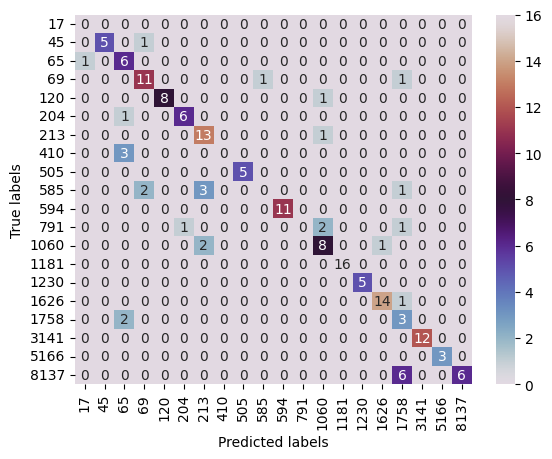

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

y_pred_ids = [index_to_id_mapping[label] for label in y_pred_labels]
y_true_ids = [index_to_id_mapping[label] for label in y_true_labels]

conf_matrix = confusion_matrix(y_true_ids, y_pred_ids, labels=list(index_to_id_mapping.values()))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=list(index_to_id_mapping.values()), yticklabels=list(index_to_id_mapping.values()), cmap="twilight")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
print(conf_matrix)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  8  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  3  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  2  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  8  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  1  0

In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division=0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.8048780487804879
F1 Score: 0.7904428017909834
Precision: 0.8006864409303434
Recall: 0.8048780487804879


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
